In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from tensorflow.keras.regularizers import l2

# Define paths and parameters
DATASET_PATH_TRAIN = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
DATASET_PATH_DEV = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
DATASET_PATH_EVAL = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH_TRAIN = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
LABEL_FILE_PATH_DEV = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
LABEL_FILE_PATH_EVAL = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction


2023-10-31 16:39:07.924086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 16:39:08.042492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-31 16:39:08.042510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-31 16:39:08.065844: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 16:39:08.551492: W tensorflow/stream_executor/pla

In [2]:
# Convert the lists to NumPy arrays
X_train = np.load('../datasets/mfcc/X_train.npy')
y_train = np.load('../datasets/mfcc/y_train.npy')
y_dev = np.load('../datasets/mfcc/y_dev.npy')
y_eval = np.load('../datasets/mfcc/y_eval.npy')


In [3]:
#Over sample
from imblearn.over_sampling import SMOTE

print(X_train.shape)
# Flatten the X_train data if needed
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Instantiate the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X_train_flattened, y_train)

print(X_resampled.shape)

# Reshape X_resampled to match the shape of the original X_train
X_resampled_reshaped = X_resampled.reshape(-1, 13, 109)


print(X_resampled_reshaped.shape)

(25380, 13, 109)
(45600, 1417)
(45600, 13, 109)


In [15]:
from collections import Counter
counter = Counter(y_resampled)
print(counter)

# Specify the file paths where you want to save the data
X_train_save_path = '../datasets/mfcc/X_train_resampled.npy'
y_train_save_path = '../datasets/mfcc/y_train_resampled.npy'

# Save X_train and y_train as .npy files
np.save(X_train_save_path, X_resampled_reshaped)
np.save(y_train_save_path, y_resampled)

Counter({0: 22800, 1: 22800})


In [16]:
X_train_resampled = np.load('../datasets/mfcc/X_train_resampled.npy')
y_train_resampled = np.load('../datasets/mfcc/y_train_resampled.npy')

In [17]:
#Define agumentation
# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_train_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X_train_resampled]

/home/sae/ENTER/envs/newconda/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=109
  warnings.warn(


In [20]:
# Convert lists to NumPy arrays
X_train_augmented_array = np.array(X_train_augmented)

# Save the NumPy arrays as .npy files
np.save('../datasets/mfcc/X_train_resampled_augmented.npy', X_train_augmented_array)

(45600, 13, 109)


In [21]:
from sklearn.utils.class_weight import compute_class_weight


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)

# Convert the class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}

In [22]:
# Convert the lists to NumPy arrays
X_train_resampled_augmented = np.load('../datasets/mfcc/X_train_resampled_augmented.npy')
X_dev_augmented = np.load('../datasets/mfcc/X_dev_augmented.npy')
X_eval_augmented = np.load('../datasets/mfcc/X_eval_augmented.npy')

print(X_train_resampled_augmented.shape)
print(X_dev_augmented.shape)
print(X_eval_augmented.shape)

(45600, 13, 109)
(24844, 13, 109)
(71237, 13, 109)


In [24]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()



# Reshape the 3D data to 2D
X_train_2d = X_train_resampled_augmented.reshape(-1, X_train_resampled_augmented.shape[-1])
X_dev_2d = X_dev_augmented.reshape(-1, X_dev_augmented.shape[-1])
X_val_2d = X_eval_augmented.reshape(-1, X_eval_augmented.shape[-1])

# Fit the scaler to your training data and transform it
X_train_normalized = scaler.fit_transform(X_train_2d)

# Transform the validation and test data using the same scaler
X_val_normalized = scaler.transform(X_val_2d)
X_dev_normalized = scaler.transform(X_dev_2d)

# Reshape the normalized data back to 3D
X_train_normalized = X_train_normalized.reshape(X_train_resampled_augmented.shape)
X_val_normalized = X_val_normalized.reshape(X_eval_augmented.shape)
X_dev_normalized = X_dev_normalized.reshape(X_dev_augmented.shape)

In [26]:
#shuffle the data
from sklearn.utils import shuffle
# Shuffle the training data
X_train_normalized, y_train = shuffle(X_train_normalized, y_train_resampled, random_state=42)

# Shuffle the validation data (if needed)
X_val_normalized, y_eval = shuffle(X_val_normalized, y_eval, random_state=42)

# Shuffle the development data
X_dev_normalized, y_dev = shuffle(X_dev_normalized, y_dev, random_state=42)

22800
22800


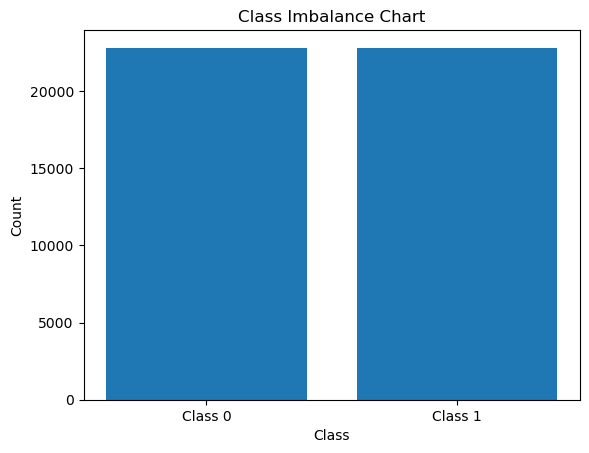

In [30]:
import matplotlib.pyplot as plt
#class imbalance here - need to oversample
count_zeros = np.count_nonzero(y_train == 0)
print(count_zeros) #22800

count_ones = np.count_nonzero(y_train == 1)
print(count_ones) #2580

# Create labels for the classes
classes = ['Class 0', 'Class 1'] #class 0 is spoof

# Count of samples in each class
counts = [count_zeros, count_ones]

# Create a bar chart
plt.bar(classes, counts)

# Add labels and a title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance Chart')

# Display the chart
plt.show()

In [27]:
#import necessary stuff for learning rate scheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Attach a callback to save learning rates to the list
class LearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        optimizer = self.model.optimizer
        lr = tf.keras.backend.get_value(optimizer.lr)
        learning_rates.append(lr)
        

In [28]:

# Define the learning rate schedule function
def exponential_decay(epoch, initial_learning_rate):
    k = 0.1
    lr = initial_learning_rate * math.exp(-k*epoch)
    return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(
    lambda epoch: exponential_decay(epoch, 0.05),
    verbose=1  # This will print the learning rate at each epoch
)

In [29]:
#final pick
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, min_lr = 0.00001)

#{'batch_size': 64, 'kernel_size': (4, 4), 'num_filters': 64, 'reg_strength': 0.001}

#Intial learning rate
initial_learning_rate = 0.05
max_time_steps = 109

# Define and compile a CNN model with L2 regularization and other improvements
model = tf.keras.Sequential([
    Conv2D(64, kernel_size=(4, 4), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
learning_rates = []

# Train the model using class weights
history = model.fit(np.expand_dims(X_train_normalized, -1), y_train, batch_size=64, epochs=100,
                validation_data=(np.expand_dims(X_dev_normalized, -1), y_dev), class_weight=class_weight_dict, callbacks = [lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.expand_dims(X_val_normalized, -1), y_eval)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Make predictions on the evaluation set
y_test_pred = model.predict(X_val_normalized)


2023-10-31 15:03:28.698466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-31 15:03:28.698619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-31 15:03:28.698705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-31 15:03:28.698788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-31 15:03:28.741259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64


Epoch 1: LearningRateScheduler setting learning rate to 0.05.
Epoch 1/100
713/713 [==============================] - 23s 31ms/step - loss: 1.5307 - accuracy: 0.8942 - val_loss: 0.9750 - val_accuracy: 0.8974 - lr: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.04524187090179798.
Epoch 2/100
713/713 [==============================] - 21s 30ms/step - loss: 0.7873 - accuracy: 0.9151 - val_loss: 2.1290 - val_accuracy: 0.6716 - lr: 0.0452

Epoch 3: LearningRateScheduler setting learning rate to 0.0409365376538991.
Epoch 3/100
713/713 [==============================] - 21s 29ms/step - loss: 0.4891 - accuracy: 0.9266 - val_loss: 0.7502 - val_accuracy: 0.9042 - lr: 0.0409

Epoch 4: LearningRateScheduler setting learning rate to 0.0370409110340859.
Epoch 4/100
713/713 [==============================] - 21s 29ms/step - loss: 0.3961 - accuracy: 0.9321 - val_loss: 0.6651 - val_accuracy: 0.8681 - lr: 0.0370

Epoch 5: LearningRateScheduler setting learning rate to 0.03351600230178

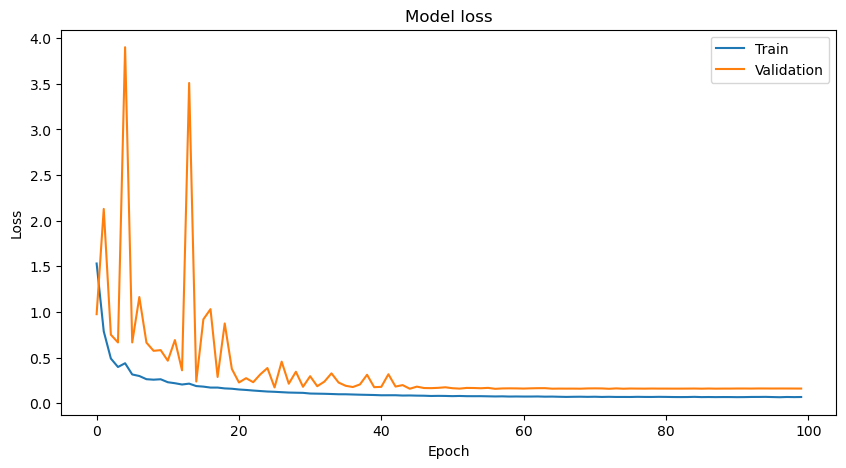

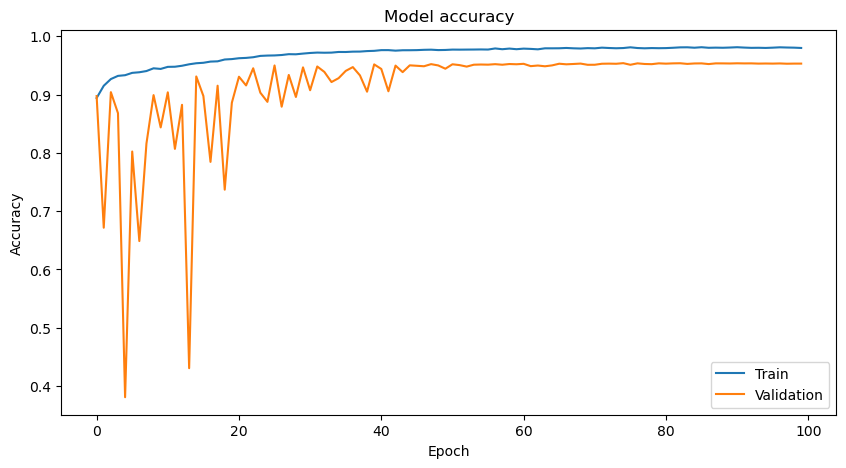

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()